<a href="https://colab.research.google.com/github/lingyixu/CS523-Deep-Learning/blob/main/GNN/GCN_Multiclass_Classification_5Fold_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load packages

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [20]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import index_to_mask, mask_to_index

In [3]:
import pandas as pd
import numpy as np
import json
import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, train_test_split

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/Shareddrives/CS523/lastFM-data/'

Mounted at /content/drive


### Load dataset: LastFM

In [14]:
df_feat = pd.read_json(drive_path + 'processed_feature.json')   # load features
arr_feat = df_feat.T.values
df_edge = pd.read_csv(drive_path + 'lastfm_asia_edges.csv')   # load edge indices
arr_edge = df_edge.T.values
df_tar = pd.read_csv(drive_path + 'lastfm_asia_target.csv', index_col=0)   # load targets
arr_tar = df_tar.values

num_nodes = arr_feat.shape[0]
num_features = arr_feat.shape[1]
num_classes = len(df_tar.target.unique())
classes = df_tar.target.sort_values().unique()

print('Dataset:')
print('====================')
print(f'Number of nodes: {arr_feat.shape[0]}')
print(f'Number of features: {num_features}')
print(f'Number of edges: {arr_edge.shape[1]}')
print(f'Number of distinct regions: {num_classes}')
print(f'All region classes: {classes}')

Dataset:
Number of nodes: 7624
Number of features: 7842
Number of edges: 27806
Number of distinct regions: 18
All region classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [7]:
graph_metadata = {'data': arr_feat, 'edge_index': arr_edge, 'label': arr_tar}

### Create GraphDataset

In [8]:
class GraphDataset(Dataset):
    
    def __init__(self, root, out_dir, metadata, transform=None, pre_transform=None, pre_filter=None):
        self.root = root
        self.out_dir = out_dir
        self.metadata = metadata
        super(GraphDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return root

    @property
    def processed_file_names(self):
        return glob.glob(f'{self.out_dir}/*.pt')

    def download(self):
        pass
    
    
    def process(self):

        self.node_features = torch.tensor(self.metadata['data'], dtype=torch.float)
        self.edge_index = torch.tensor(self.metadata['edge_index'], dtype=torch.int64)
        self.label = torch.tensor(self.metadata['label'], dtype=torch.int64)

        data = Data(x = self.node_features, 
                    edge_index = self.edge_index,
                    # edge_attr = None,
                    y = self.label)

        torch.save(data, f'{self.out_dir}/data.pt')

    def len(self):
        return self.node_features.shape[0]

    def get(self):
        data = torch.load(f'{self.out_dir}/data.pt')
        return data

In [9]:
root = ''
out_dir = 'graph_data'
os.mkdir(out_dir)
metadata = graph_metadata
dataset = GraphDataset(root=root, out_dir=out_dir, metadata=metadata)

Processing...
Done!


In [10]:
# inspect the graph dataset
data = dataset.get()
print()
print(data)
print('=============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')


Data(x=[7624, 7842], edge_index=[2, 27806], y=[7624, 1])
Number of nodes: 7624
Number of edges: 27806


In [11]:
# set data to cuda
data.to(device)  

Data(x=[7624, 7842], edge_index=[2, 27806], y=[7624, 1])

### Train/test split for 5-fold cross validation

In [17]:
def graphdataset_split(n_fold):

    X = np.arange(num_nodes)
    splits = KFold(n_fold, shuffle=True, random_state=42)   # fix the seed to make the split reproducible
    splits.split(X)
    
    train_sets = []
    test_sets = []

    for train_index, test_index in splits.split(X):
        train_sets.append(list(train_index))
        test_sets.append(list(test_index))

    return train_sets, test_sets

In [18]:
n_fold = 5
train_sets, test_sets = graphdataset_split(n_fold)

for i in range(n_fold):
    print('================')
    print(f'Fold {i+1}:')
    print(f'Train nodes: {len(train_sets[i])}')
    print(f'Test nodes: {len(test_sets[i])}')

Fold 1:
Train nodes: 6099
Test nodes: 1525
Fold 2:
Train nodes: 6099
Test nodes: 1525
Fold 3:
Train nodes: 6099
Test nodes: 1525
Fold 4:
Train nodes: 6099
Test nodes: 1525
Fold 5:
Train nodes: 6100
Test nodes: 1524


In [21]:
# create masks
train_masks = []
test_masks = []

for i in range(n_fold):
    
    train_mask = index_to_mask(torch.tensor(train_sets[i]), size=num_nodes).to(device)
    test_mask = index_to_mask(torch.tensor(test_sets[i]), size=num_nodes).to(device)
    
    train_masks.append(train_mask)
    test_masks.append(test_mask)

### Build GNN

In [22]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels1, hidden_channels2, hidden_channels3):
        super().__init__()
        # torch.manual_seed(42)
        self.conv1 = GCNConv(num_features, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, hidden_channels3)
        self.linear = torch.nn.Linear(hidden_channels3, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.1)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.1)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.1)
        x = self.linear(x)
        return x

In [23]:
criterion = torch.nn.CrossEntropyLoss()

### Model training and testing

In [52]:
# set params
hidden_channels1 = 512
hidden_channels2 = 256
hidden_channels3 = 128
lr = 5e-4
weight_decay = 5e-4
epoch = 50
save_results = False

In [27]:
def train(model, train_mask):
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[train_mask], data.y[train_mask].flatten())
      loss.backward()
      optimizer.step()
      # return loss

def test(model, test_mask):
      model.eval()
      out = model(data.x, data.edge_index)
      loss = criterion(out[test_mask], data.y[test_mask].flatten()).cpu().detach().item()
      pred = out.argmax(dim=1)
      correct = pred[test_mask] == data.y[test_mask].flatten()
      acc = correct.sum() / test_mask.sum()
      return loss, acc.cpu().detach().item()

In [53]:
# cross validation
train_acc_all = []
test_acc_all = []
train_loss_all = []
test_loss_all = []

for i in range(n_fold):   # loop through folds

    print(f'===== Fold {i+1} ======')
    
    # initialize model and optimizer
    model = GCN(hidden_channels1, hidden_channels2, hidden_channels3)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # accuracy per epoch
    train_acc_epoch = []
    test_acc_epoch = []
    # loss per epoch
    train_loss_epoch = []
    test_loss_epoch = []

    for e in range(epoch):   # loop through epochs
        
        train(model, train_masks[i])
        train_loss, train_acc = test(model, train_masks[i])
        test_loss, test_acc = test(model, test_masks[i])
        
        # save loss and accuracy history
        train_acc_epoch.append(train_acc)
        test_acc_epoch.append(test_acc)
        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
                
        # save model and output
        if (e == epoch-1) and (save_results==True):
            torch.save(model, f'/content/drive/Shareddrives/CS523/Notebooks/model/GCN/fold_{i+1}.pt')
            # torch.save(out, f'/content/drive/Shareddrives/CS523/Notebooks/output/GCN/fold_{i+1}.pt')

        print(f'Epoch: {e+1:02d}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')

        torch.cuda.empty_cache()

    train_acc_all.append(train_acc_epoch)
    test_acc_all.append(test_acc_epoch)
    train_loss_all.append(train_loss_epoch)
    test_loss_all.append(test_loss_epoch)

===== Fold 1 ======
Epoch: 01, Train loss: 2.7052, Test loss: 2.6986
Epoch: 02, Train loss: 2.4874, Test loss: 2.4765
Epoch: 03, Train loss: 2.2666, Test loss: 2.2638
Epoch: 04, Train loss: 2.0858, Test loss: 2.0723
Epoch: 05, Train loss: 1.9246, Test loss: 1.9224
Epoch: 06, Train loss: 1.7837, Test loss: 1.7631
Epoch: 07, Train loss: 1.6515, Test loss: 1.6411
Epoch: 08, Train loss: 1.5327, Test loss: 1.5064
Epoch: 09, Train loss: 1.4152, Test loss: 1.4030
Epoch: 10, Train loss: 1.3212, Test loss: 1.3303
Epoch: 11, Train loss: 1.2316, Test loss: 1.2527
Epoch: 12, Train loss: 1.1678, Test loss: 1.1812
Epoch: 13, Train loss: 1.1184, Test loss: 1.1334
Epoch: 14, Train loss: 1.0630, Test loss: 1.0985
Epoch: 15, Train loss: 1.0166, Test loss: 1.0600
Epoch: 16, Train loss: 0.9724, Test loss: 1.0133
Epoch: 17, Train loss: 0.9368, Test loss: 1.0042
Epoch: 18, Train loss: 0.8995, Test loss: 0.9583
Epoch: 19, Train loss: 0.8665, Test loss: 0.9512
Epoch: 20, Train loss: 0.8324, Test loss: 0.9434


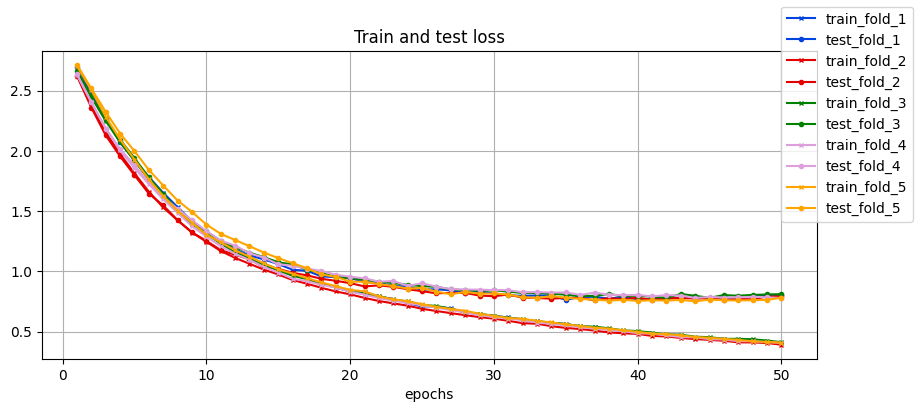

In [54]:
# plot train and test loss
fig, ax = plt.subplots(figsize=(10,4))
colors = ['#0343DF', '#E50000', '#008000', '#DDA0DD', '#FFA500']
for i in range(n_fold):
    ax.plot(range(1,len(train_loss_all[i])+1), train_loss_all[i], '-x', markersize=3, label=f'train_fold_{i+1}', color=colors[i])
    ax.plot(range(1,len(test_loss_all[i])+1), test_loss_all[i], '-o', markersize=3, label=f'test_fold_{i+1}', color=colors[i])
# ax.set_xticks(np.arange(1, epoch+1))
ax.grid()
ax.set_title('Train and test loss')
ax.set_xlabel('epochs')
fig.legend()
fig.show()

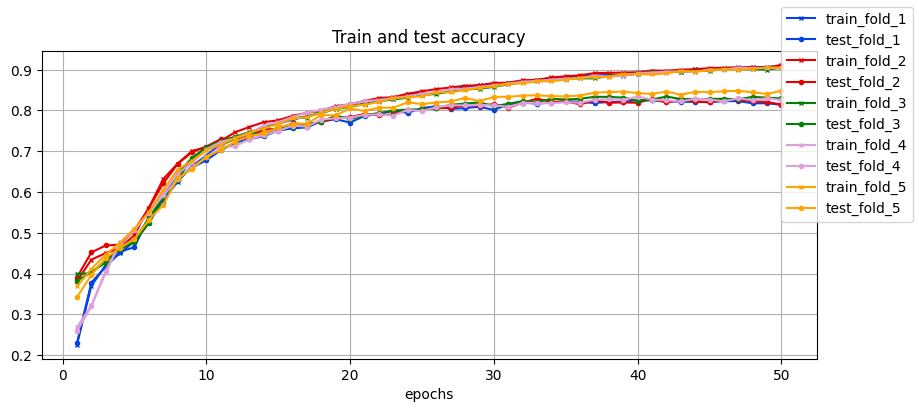

In [55]:
# plot train and test accuracy
fig, ax = plt.subplots(figsize=(10,4))
for i in range(n_fold):
    ax.plot(range(1,len(train_acc_all[i])+1), train_acc_all[i], '-x', markersize=3, label=f'train_fold_{i+1}', color=colors[i])
    ax.plot(range(1,len(test_acc_all[i])+1), test_acc_all[i], '-o', markersize=3, label=f'test_fold_{i+1}', color=colors[i])
# ax.set_xticks(np.arange(1, epoch+1))
ax.grid()
ax.set_title('Train and test accuracy')
ax.set_xlabel('epochs')
fig.legend()
fig.show()

In [56]:
# print out average accuracy
acc_list = []
for i in range(n_fold):
    acc = test_acc_all[i][-1]
    acc_list.append(acc)
    print(f'Fold {i+1} test accuracy: {acc:.4f}')
print(f'Average accuracy: {np.mean(acc_list):.4f}')

Fold 1 test accuracy: 0.8138
Fold 2 test accuracy: 0.8144
Fold 3 test accuracy: 0.8295
Fold 4 test accuracy: 0.8256
Fold 5 test accuracy: 0.8484
Average accuracy: 0.8263
